# Creating Project

In [7]:
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
import mitzu.model as M


p = M.Project(
        project_name="trino_test_project",
        event_data_tables=[
            M.EventDataTable.create(
                table_name="sub_events",
                schema="tiny",
                event_name_alias="user_subscribe",
                event_time_field="subscription_time",
                user_id_field="subscriber_id",
            ),
            M.EventDataTable.create(
                table_name="web_events",
                schema="tiny",
                event_name_field="event_name",
                event_time_field="event_time",
                date_partition_field="event_time",
                user_id_field="user_id",
                event_specific_fields=["event_properties"],
            ),
        ],
        discovery_settings=M.DiscoverySettings(
            end_dt=datetime(2021, 4, 1),
            lookback_days=10,
            property_sample_rate=10,
        ),
        connection=M.Connection(
            connection_name="trino_hive_connection",
            connection_type=M.ConnectionType.TRINO,
            user_name="test",
            secret_resolver=None,            
            catalog="minio",
            host="localhost",
        ),
    )

# Saving Project to File

In [13]:
dp = p.discover_project()
dp.save_to_project_file("trino_test_project")

Successfully finished dataset discovery.                                                                                                   


# Loading Project

In [14]:
dp = M.DiscoveredProject.load_from_project_file("trino_test_project")
m = dp.create_notebook_class_model()

# Product Analytics From Loaded Project

In [15]:
(m.page_visit >> m.search).config(conv_window="7 days",time_group="total",group_by=m.page_visit.event_properties.url).print_sql()

WITH anon_1 AS
  (SELECT tiny.web_events.user_id AS _cte_user_id,
          tiny.web_events.event_time AS _cte_datetime,
          web_events.event_properties.url AS _cte_group
   FROM tiny.web_events
   WHERE tiny.web_events.event_name = 'page_visit'
     AND tiny.web_events.event_time >= timestamp '2021-03-02 00:00:00'
     AND tiny.web_events.event_time <= timestamp '2021-04-01 00:00:00'
     AND date(tiny.web_events.event_time) >= date('2021-03-02')
     AND date(tiny.web_events.event_time) <= date('2021-04-01')),
     anon_2 AS
  (SELECT tiny.web_events.user_id AS _cte_user_id,
          tiny.web_events.event_time AS _cte_datetime,
          NULL AS _cte_group
   FROM tiny.web_events
   WHERE tiny.web_events.event_name = 'search'
     AND tiny.web_events.event_time >= timestamp '2021-03-02 00:00:00'
     AND tiny.web_events.event_time <= timestamp '2021-04-08 00:00:00'
     AND date(tiny.web_events.event_time) >= date('2021-03-02')
     AND date(tiny.web_events.event_time) <= date

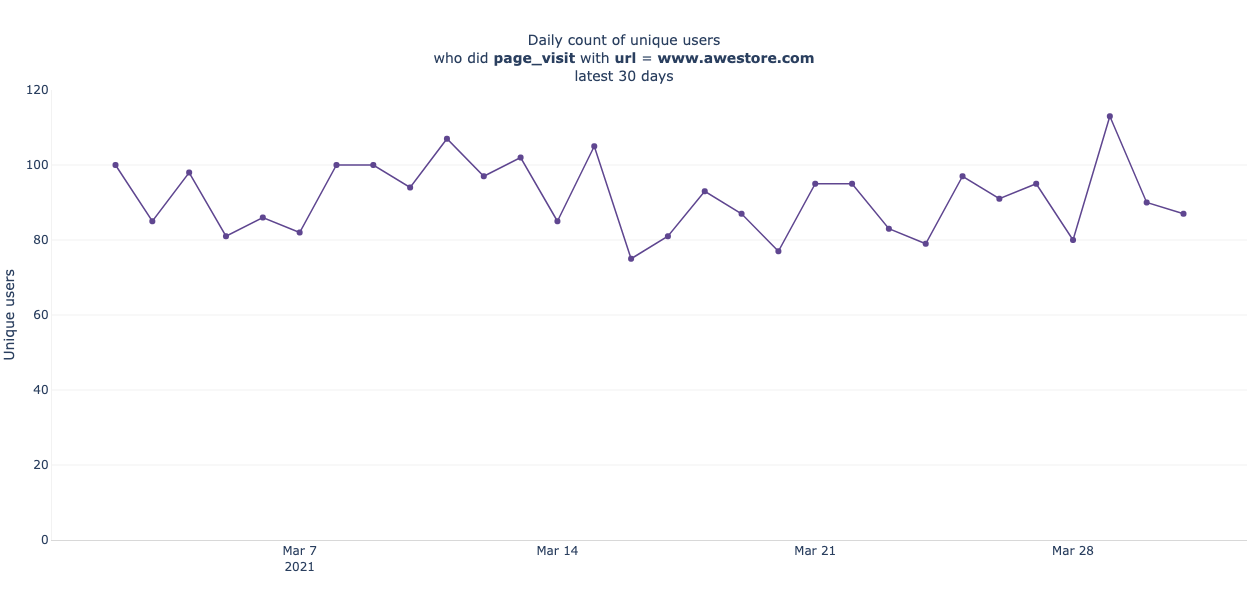

In [21]:
m.page_visit.event_properties.url.is_www_awestore_com.config(chart_type="line")

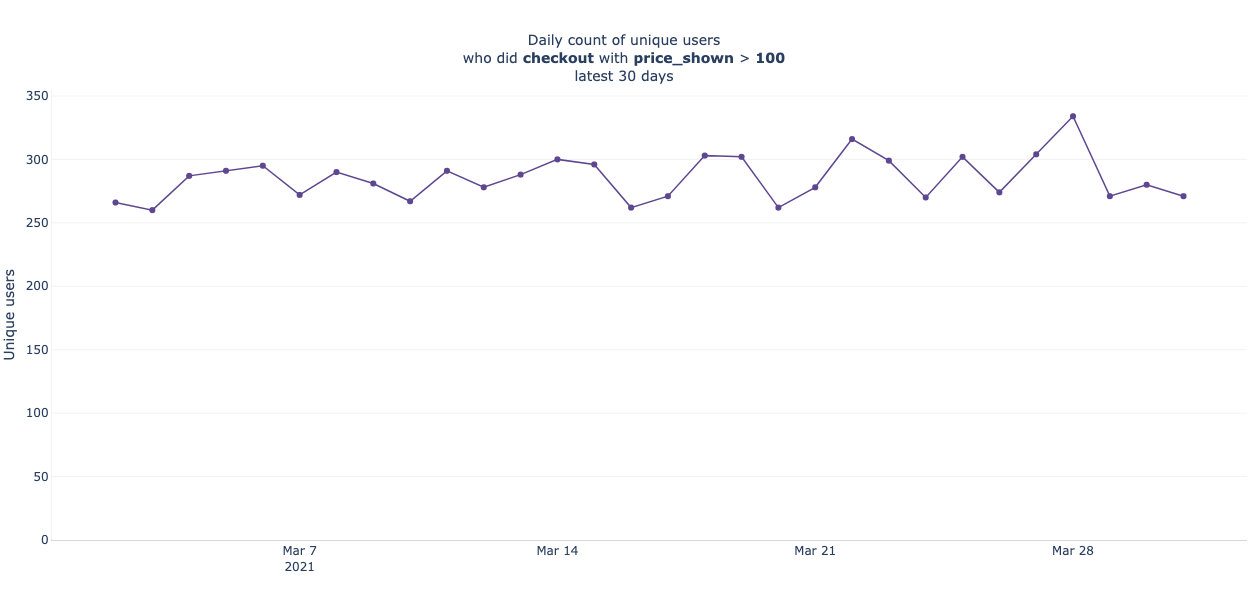

In [22]:
(m.checkout.event_properties.price_shown > 100).config(chart_type="line")

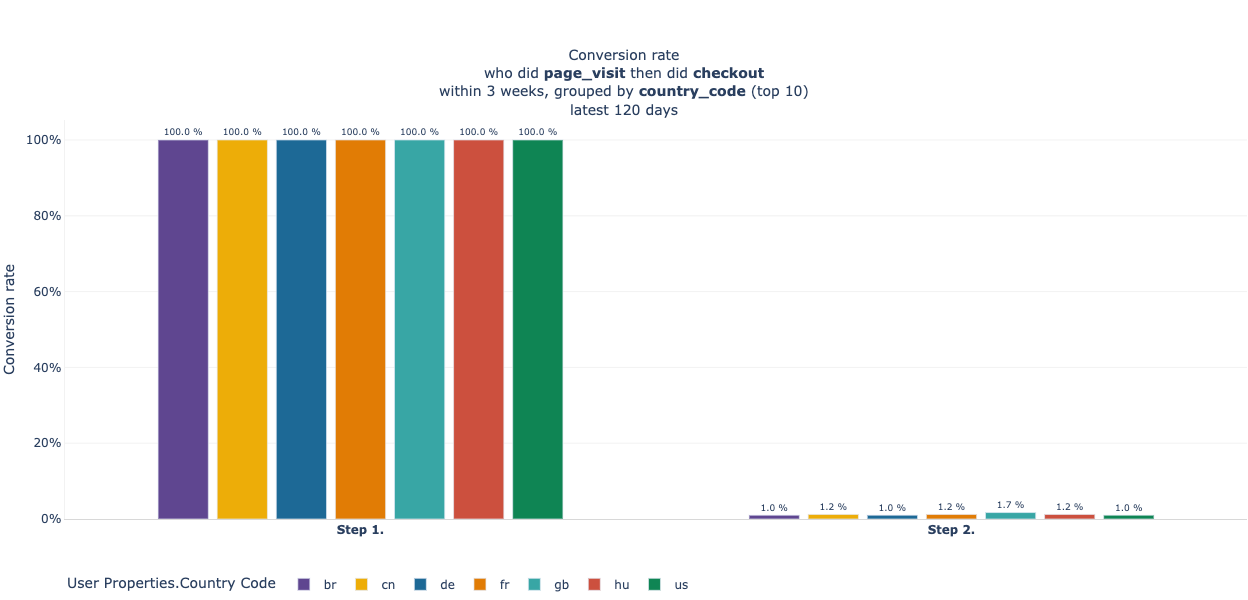

In [23]:
(m.page_visit >> m.checkout).config(time_group="total", 
                                    conv_window="3 week", 
                                    group_by=m.page_visit.user_properties.country_code, 
                                    lookback_days=120)

In [24]:
(m.page_visit >> m.checkout).config(time_group="total", 
                                    conv_window="3 week", 
                                    group_by=m.page_visit.user_properties.country_code, 
                                    lookback_days=120).print_sql()

WITH anon_1 AS
  (SELECT tiny.web_events.user_id AS _cte_user_id,
          tiny.web_events.event_time AS _cte_datetime,
          web_events.user_properties.country_code AS _cte_group
   FROM tiny.web_events
   WHERE tiny.web_events.event_name = 'page_visit'
     AND tiny.web_events.event_time >= timestamp '2020-12-02 00:00:00'
     AND tiny.web_events.event_time <= timestamp '2021-04-01 00:00:00'
     AND date(tiny.web_events.event_time) >= date('2020-12-02')
     AND date(tiny.web_events.event_time) <= date('2021-04-01')),
     anon_2 AS
  (SELECT tiny.web_events.user_id AS _cte_user_id,
          tiny.web_events.event_time AS _cte_datetime,
          NULL AS _cte_group
   FROM tiny.web_events
   WHERE tiny.web_events.event_name = 'checkout'
     AND tiny.web_events.event_time >= timestamp '2020-12-02 00:00:00'
     AND tiny.web_events.event_time <= timestamp '2021-04-22 00:00:00'
     AND date(tiny.web_events.event_time) >= date('2020-12-02')
     AND date(tiny.web_events.event_tim

In [26]:
# dp.display_inline_dashboard(port=8083)

# or when your notebook does not support iframes
# dp.display_external_dashboard(port=8083)